# Beirut damage propagated in NetConf
This notebook aims to get Beirut damage data associated with satellite imagery and run belief propagation on the data using NetConf

In [25]:
# Package imports
import math
import json
import requests
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import ipyleaflet
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipyleaflet import Map, basemaps, GeoData, CircleMarker, Popup, GeoJSON, LegendControl
from ipywidgets import HTML
from IPython.display import Image, display
from shapely.geometry import Polygon, Point

import descarteslabs as dl
import descarteslabs.workflows as wf

import netconf.netconf as nc

In [33]:
# Define variables
# Location variables
lat, lon, zoom = 33.8975, 35.5063, 14 # Map properties

# Building Footprints variables
buildings = "./data/beirutBuildingFootprints.geojson"

# Damage Assessment variables
dataFile = "./data/geopalData.csv" # GeoPal data

# A priori damage beliefs (green, yellow, red decisions)
gb, yb, rb = 0.1, 0.7, 0.95
ratioWeight = 1

_____________
## 1 - Import Datasets

In [3]:
# Import footprints geojson
# Display header 
builds = gpd.read_file(buildings)
pd.set_option('display.max_columns', None)
fps = gpd.GeoDataFrame(builds[['id','building','name']], geometry=builds.geometry)
fps.head()

,id,building,name,geometry
0,relation/71853,yes,None,"POLYGON ((35.4894536 33.8946995, 35.4894132 33..."
1,relation/6678216,residential,None,"POLYGON ((35.524633 33.8898401, 35.5246194 33...."
2,relation/6996546,school,Collège des Trois Docteurs,"POLYGON ((35.5185524 33.8949802, 35.5185834 33..."
3,relation/7000797,school,كلية القلب الأقدس,"(POLYGON ((35.5106324 33.895221, 35.5106476 33..."
4,relation/7026674,yes,None,"POLYGON ((35.5053153 33.893788, 35.5048335 33...."


In [4]:
# Import GeoPal data
allData = pd.read_csv(dataFile)
# Extract locations from joint column in database
locations, mapPoints = allData['get location - الموقع_w_2049198'], allData['point on map - الموقع على الخريطة_w_2049199']
lats, lons = np.zeros([len(locations), 1]),  np.zeros([len(locations), 1])
for i in range(len(locations)):
    loc = locations[i]
    if type(loc) is float or (type(loc) is str and loc[0].isalpha()):
        mp = mapPoints[i]
        if type(mp) is str and mp[0].isdigit():
            try: lats[i], lons[i] = mp.split(' ')[0], mp.split(' ')[1]
            except: lats[i], lons[i] = mp.split(',')[0], mp.split(',')[1] # Deal with rogue commas instead of space
    else: lats[i], lons[i] = loc.split(' ')[0], loc.split(' ')[1]

# Extract columns of useful data
data = pd.DataFrame({
    'id': allData['Job ID'],
    'area': allData['plot area - المنطقة العقارية_w_2049201'],
    'damage': allData['structural damage level - مستوى الضرر الأنشائي للمبنى_w_2049205'],
    'floors': allData['number of floors - عدد الطوابق_w_2049208'],
    'units': allData['number of units - عدد الشقق_w_2049209'],
    'use': allData['building use - وجهة الاستعمال للمبنى_w_2049210'],
    'photos': allData['take pictures - التقاط صور_w_2049222'],
    'decision': allData['decision - القرار_w_2049224']    
})

# Create geodatabase merging locations with useful data
assessments = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(lons, lats),crs={'init': 'epsg:4326'})

# Filter for non located values
locs = assessments[assessments.geometry.x != 0]
locs.head()

,id,area,damage,floors,units,use,photos,decision,geometry
0,278,El Bachoura الباشورة,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.5577379 33.8830089)
2,280,Achrafieh الأشرفية,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.557755 33.8830024)
3,281,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,5.0,5.0,"Residential سكني,Commercial تجاري",NaN,NaN,POINT (35.5577587 33.8830063)
5,283,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,5.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577435 33.8830157)
6,284,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,8.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577312 33.8829998)


____________
## 2 - Combine building footprints with damage assessments

In [5]:
# Get joint geodataframe of building footprints with damage assessments
joint = gpd.sjoin(fps, locs, how="left", op='contains').dropna(subset=['decision'])
joint.head()

,id_left,building,name,geometry,index_right,id_right,area,damage,floors,units,use,photos,decision
1,relation/6678216,residential,None,"POLYGON ((35.524633 33.8898401, 35.5246194 33....",1111.0,2108,Achrafieh الأشرفية,Not affected - غير متأذي,3.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
19,relation/7460523,yes,العاملية,"(POLYGON ((35.5059967 33.8827747, 35.5056111 3...",5630.0,10808,El Mazraa المزرعة,Not affected - غير متأذي,5.0,4.0,"Commercial تجاري, Residential سكني",https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
24,relation/7803503,yes,None,"POLYGON ((35.4971487 33.8855667, 35.4971174 33...",5520.0,10670,El Msaytbeh المصيطبة,Not affected - غير متأذي,7.0,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
24,relation/7803503,yes,None,"POLYGON ((35.4971487 33.8855667, 35.4971174 33...",5505.0,10652,El Msaytbeh المصيطبة,Not affected - غير متأذي,8.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
27,relation/8056967,yes,None,"POLYGON ((35.5222517 33.8889111, 35.5217716 33...",811.0,1300,Achrafieh الأشرفية,Not affected - غير متأذي,2.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)


In [6]:
def to_geodata(gdf, color):
    plotGdf = GeoData(geo_dataframe = gdf,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':0.9, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.8, 'fillColor': color, 'weight': 3},
                          name = 'Images')
    return plotGdf

In [7]:
m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'GREEN (inspected) أخضر (تم دراسته)'],'green'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)'],'yellow'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء'],'red'))

if not 'l1' in globals(): # Add legend if forming map for first time
    l1 = legend = LegendControl({"No Restrictions":"#008000", "Restricted Use":"#FFFF00", "Unsafe/Evacuated":"#FF0000", "No Decision":"#0000FF"}, name="Decision", position="bottomleft")
    m1.add_control(l1)
m1

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [8]:
# Display map upon which to draw Polygon for analysis
r = 0.01
testPoly = ipyleaflet.Polygon(locations=[(lat-r, lon-r), (lat-r, lon+r), (lat+r, lon+r),(lat+r, lon-r)], color="yellow", fill_color="yellow", transform=True)

m1.add_layer(testPoly)

____________
## 3 - Get ratio of Sentinel-1 pixel intensities for AOI

In [9]:
# Define function for retrieving satellite imagery from Descartes platform and displaying on map
def getImage(satellite,bands,st_date,end_date,time,opacity=1,mapNum=m1,cloudFraction=0.1):
    img = wf.ImageCollection.from_id(satellite,start_datetime=st_date[time], end_datetime=end_date[time])
    if 'sentinel-2' in satellite: # Use sentinel cloud-mask band if available
        img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
        img = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
    mos = (img.mosaic().pick_bands(bands))
    globals()['mos_'+str(time+1)+str(bands)] = mos
    display = mos.visualize('Image '+str(time+1)+str(bands), map=mapNum)
    display.opacity = opacity

In [10]:
# Initialise map
m2 = wf.interactive.MapApp()
m2.center, m2.zoom = (lat, lon), zoom

satellite, bands = "sentinel-1:GRD", ['vh','vv']
st_date, end_date = ['2020-07-30T00:00:00.000Z', '2020-08-05T00:00:00.000Z'], ['2020-07-30T14:00:00.000Z', '2020-08-05T14:00:00.000Z'] # Timeframes for before-after imagery: start 1, start 2; end 1 ,end 2

# Loop over dates (time 1 & time 2)
for i in range(len(st_date)):
    getImage(satellite, bands, st_date, end_date, i, 0, m2)
    for j in bands:
        getImage(satellite, j, st_date, end_date, i, 0, m2)
    
# Calculate logarithmic ratio for RGB images and display
ratio = wf.log10(globals()['mos_1'+str(bands)] / globals()['mos_2'+str(bands)])
rdisplay = ratio.visualize('Ratio' ,map=m2)
rdisplay.opacity = 1
m2.add_layer(testPoly)
m2


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


________________
## 4 - Associate damage belief with pixels as nodes and pixel borders as edges

In [11]:
# Area of interest defined by test polygon
AOI = dl.scenes.AOI(bounds = (testPoly.locations[0][0]['lng'], testPoly.locations[0][0]['lat'], testPoly.locations[0][2]['lng'], testPoly.locations[0][2]['lat']),
                    resolution=20,
                    crs=m2.geocontext().crs)

# Compute values from ratio within AOI
change = ratio.compute(geoctx = AOI)


Job ID: 5cd77fe8b00a214179f4c296fee9dff71fd3fe6775ee8e9c
[######] | Steps: 10/10 | Stage: SUCCEEDED                                    

In [78]:
# Assign initial beliefs to each pixel
bounds = AOI.bounds
longs, lats = np.linspace(bounds[0],bounds[2],change.geocontext['arr_shape'][1]), np.linspace(bounds[3],bounds[1],change.geocontext['arr_shape'][0])
xm, ym = np.meshgrid(longs,lats)
initial = gpd.GeoDataFrame(pd.DataFrame(np.concatenate((np.ones([len(longs)*len(lats),2])*0.5, change.ndarray[0].reshape(-1,1), change.ndarray[1].reshape(-1,1)), axis=1), columns = ['noDmg','dmg','vh','vv']), geometry=gpd.points_from_xy(xm.reshape(-1), ym.reshape(-1)),crs={'init': 'epsg:4326'})

In [79]:
# Assign updated beliefs to pixels within assessed building footprints
nodes = gpd.sjoin(initial, joint[['geometry','decision']], how='left', op='within')
nodes = nodes[~nodes.index.duplicated(keep='first')]
nodes.loc[nodes.decision == 'GREEN (inspected) أخضر (تم دراسته)', ['noDmg', 'dmg']] = 1-gb, gb
nodes.loc[nodes.decision == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)', ['noDmg', 'dmg']] = 1-yb, yb
nodes.loc[nodes.decision == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء', ['noDmg', 'dmg']] = 1-rb, rb
nodes.head()

,noDmg,dmg,vh,vv,geometry,index_right,decision
0,0.5,0.5,0.000000,0.0,POINT (35.49423991416309 33.89500054969758),NaN,NaN
1,0.5,0.5,0.084321,0.0,POINT (35.49442168644281 33.89500054969758),NaN,NaN
2,0.5,0.5,0.000000,0.0,POINT (35.49460345872254 33.89500054969758),NaN,NaN
3,0.5,0.5,-0.035472,0.0,POINT (35.49478523100227 33.89500054969758),NaN,NaN
4,0.5,0.5,0.000000,0.0,POINT (35.494967003282 33.89500054969758),NaN,NaN


In [80]:
# Create edges between nodes - i.e. adjacent pixels
edges = []
x, l = len(longs), len(nodes)
for i in nodes.index:
    if not i % x == x-1: edges.append([i,i+1]) # Pixel to right (edge to left is equivalent to previous edge to right)
    if not i > l-x-1: edges.append([i,i+x]) # Pixel below (edge above is accounted for is equivalent to previous edge below)

In [81]:
nodes.loc[nodes.decision == 'GREEN (inspected) أخضر (تم دراسته)']
#edges

,noDmg,dmg,vh,vv,geometry,index_right,decision
71,0.9,0.1,0.000000,0.000000,POINT (35.49733004291846 33.89455767382067),1687.0,GREEN (inspected) أخضر (تم دراسته)
133,0.9,0.1,-0.098244,-0.041393,POINT (35.49551232012118 33.89396717265146),7983.0,GREEN (inspected) أخضر (تم دراسته)
151,0.9,0.1,0.008774,-0.156120,POINT (35.49551232012118 33.89381954735916),7983.0,GREEN (inspected) أخضر (تم دراسته)
158,0.9,0.1,0.121506,0.000000,POINT (35.49678472607928 33.89381954735916),7990.0,GREEN (inspected) أخضر (تم دراسته)
163,0.9,0.1,-0.043832,-0.026215,POINT (35.49442168644281 33.89367192206685),7415.0,GREEN (inspected) أخضر (تم دراسته)
171,0.9,0.1,0.207125,0.235405,POINT (35.49587586468063 33.89367192206685),1441.0,GREEN (inspected) أخضر (تم دراسته)
209,0.9,0.1,-0.034006,0.019150,POINT (35.49623940924009 33.89337667148224),4765.0,GREEN (inspected) أخضر (تم دراسته)
227,0.9,0.1,0.012499,-0.052339,POINT (35.49623940924009 33.89322904618994),4765.0,GREEN (inspected) أخضر (تم دراسته)
245,0.9,0.1,0.012499,-0.052339,POINT (35.49623940924009 33.89308142089764),4765.0,GREEN (inspected) أخضر (تم دراسته)
265,0.9,0.1,0.039941,0.000000,POINT (35.49660295379955 33.89293379560534),4764.0,GREEN (inspected) أخضر (تم دراسته)


____________
## 5 - Run NetConf for belief propagation

Text(0.5, 1.0, 'A priori damage probability')

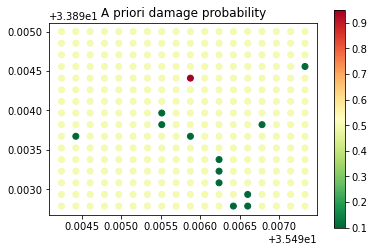

In [82]:
# Map for beliefs prior
prePlot = nodes.plot(column='dmg', cmap='RdYlGn_r', legend=True)
prePlot.set_title('A priori damage probability')

In [85]:
priors = np.array(nodes[['noDmg','dmg']])
beliefs, _ = nc.netconf(np.array(edges),priors,verbose=True)
if not os.path.exists('./results'): os.mkdir('results')
np.savetxt('results/BeirutBeliefs.csv', beliefs, delimiter=",", fmt='%s')
print('Output written results/BeirutBeliefs.csv\n')

It	max{del(B)}	del(label)

0	3.28513e-01		5

1	1.33411e-01		8

2	5.71873e-02		9

3	2.63852e-02		11

4	1.18750e-02		11

5	5.54706e-03		11

6	2.55073e-03		9

7	1.19438e-03		7

8	5.65622e-04		7

9	2.69050e-04		7

10	1.30428e-04		5

11	6.37222e-05		5

Output written results/BeirutBeliefs.csv



Text(0.5, 1.0, 'Updated damage likelihood')

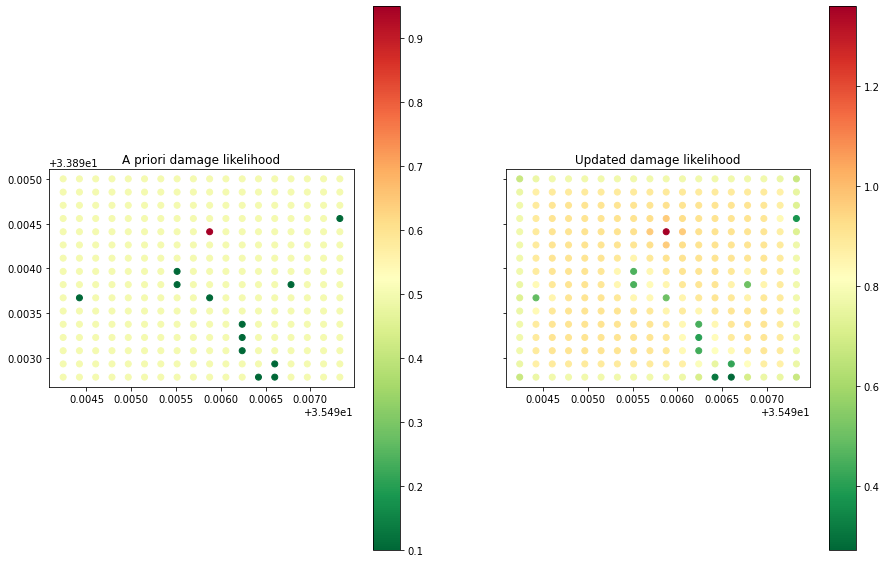

In [86]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,10),ncols=2, sharex=True, sharey=True)
prePlot = nodes.plot(ax=ax1, column='dmg', cmap='RdYlGn_r', legend=True)
postPlot = nodes.plot(ax=ax2, column=beliefs[:,1], cmap='RdYlGn_r', legend=True)
prePlot.set_title('A priori damage likelihood')
postPlot.set_title('Updated damage likelihood')